In [1]:
import sys
import time
import os
import subprocess
import math
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table, Column 
from scipy.stats import linregress
from scipy import interpolate
from scipy import polyval, polyfit
from scipy.optimize import curve_fit
from scipy import odr
import pylab as py
from matplotlib import gridspec
import sklearn.datasets as ds
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
import corner
import emcee
import scipy.optimize as op
from scipy.linalg import cholesky, inv,det
from scipy.optimize import minimize
import random
from astropy.table import Table, Column
from linear_mcmc import *

from redTools import *
from Kcorrect import *

In [2]:
def linfit(x, m, b):
    return m * x + b
def linfit_b(x, m):
    return m * x
def linfit_m(x, b):
    return x+b

In [3]:
########################################################
def getReddening_err(table, band1='r', band2='w2'):
    
    pc0  = table['P0_w2']
    P1W2p = table['P0_w2p']
    R_source = table['R_source']
    indx, = np.where(R_source==0)
    pc0[indx] = P1W2p[indx]
    
    Epc0 = table['P0_w2_e']
    inc  = table['inc']   
    Einc = table['inc_e']
    
    if band1=='w2':
        a,b,c,d, alpha, beta, theta, Ealpha, Ebeta = getReddening_params(band1='w1', band2=band2)
        gamma = (a*pc0**3+b*pc0**2+c*pc0+d)
        d_gamma = np.abs((3*a*pc0**2+2*b*pc0+c)*Epc0)
        gamma = gamma/3.107
        d_gamma = gamma/3.107
    else:
        a,b,c,d, alpha, beta, theta, Ealpha, Ebeta = getReddening_params(band1=band1, band2=band2)
        gamma = (a*pc0**3+b*pc0**2+c*pc0+d)
        d_gamma = np.abs((3*a*pc0**2+2*b*pc0+c)*Epc0)
    
    indx, = np.where(gamma<0)
    gamma[indx]=0
    d_gamma[indx]=0

    q2 = 10**(-1.*theta)
    F = log_a_b(inc, q2)
    dF2 = Elogab2(inc, q2, Einc)
    dM2 = dF2*(a*pc0**3+b*pc0**2+c*pc0+d)**2+(F*(3*a*pc0**2+2*b*pc0+c)*Epc0)**2
    
    Aj_e2 = np.sqrt(dM2)
    Aj = F*gamma
    
    return Aj_e2
########################################################

In [4]:
table   = np.genfromtxt('corrected_mags_linewidth_all.csv' , delimiter='|', 
                        filling_values=-1, names=True, dtype=None, encoding=None)
pgc = table['pgc']

print len(pgc)

10736


In [94]:
def makeZP(table, band='i', reject=[], weird=[], clusterName='ZP calibrators', nest='', slope=None):
    
    ctl   = np.genfromtxt('zp_photom_reduced.csv' , delimiter='|', filling_values=-1, 
                          names=True, dtype=None, encoding=None)
    PGC  = ctl['PGC']
    ID   = ctl['Name']
    dist = ctl['d']
    
    print len(PGC)
    
    pgc       = table['pgc']
    logWimx   = table['logWimx']
    logWimx_e = table['logWimx_e']
    Vhel      = table['Vhel']

    Aj_e2     = getReddening_err(table, band1=band, band2='w2')


    mag = table[band+'_sss']
    mag_e = np.sqrt((mag*0.+0.05)**2+Aj_e2**2)    
    
    pgc_      = []
    logWimx_  = []
    logWimx_e_= []
    mag_      = []
    mag_e_    = []
    Sqlt_     = []
    Wqlt_     = []
    dist_     = []
    ID_       = []
    
    for i, idd in enumerate(pgc):
        if idd in PGC and not idd in reject:
            indx, = np.where(PGC==idd)
            if mag[i]>5 and mag[i]<22:
                    pgc_.append(idd)
                    logWimx_.append(logWimx[i])
                    logWimx_e_.append(logWimx_e[i])
                    mag_.append(mag[i])
                    mag_e_.append(mag_e[i])
                    Sqlt_.append(table['Sqlt'][i])
                    Wqlt_.append(table['Wqlt'][i])     
                    dist_.append(dist[indx][0])
                    ID_.append(ID[indx][0])
            
            
    pgc_=np.asarray(pgc_)
    logWimx_=np.asarray(logWimx_)
    logWimx_e_=np.asarray(logWimx_e_)
    mag_=np.asarray(mag_)
    mag_e_=np.asarray(mag_e_)
    Sqlt_=np.asarray(Sqlt_)
    Wqlt_=np.asarray(Wqlt_)
    dist_=np.asarray(dist_)
    ID_=np.asarray(ID_)
    N = len(pgc_)
    dofit = np.zeros(N)
      
    for i in range(N):
        if not pgc_[i] in weird:
            if not band in ['w1','w2'] and Sqlt_[i]>=1:
                dofit[i]=1
            elif band in ['w1','w2'] and Wqlt_[i]>=1:
                dofit[i]=1
            else:
                dofit[i]=2
        else:
            dofit[i]=2
            
    indx,       = np.where(dofit==2)
    pgc_w       = pgc_[indx]
    logWimx_w   = logWimx_[indx]
    logWimx_e_w = logWimx_e_[indx]
    mag_w       = mag_[indx]
    mag_e_w     = mag_e_[indx]
    dist_w      = dist_[indx]
    ID_w        = ID_[indx]
    MAG_w       = mag_w - 5*np.log10(dist_w) - 25.
    
    indx,       = np.where(dofit==1)
    pgc_        = pgc_[indx]
    logWimx_    = logWimx_[indx]
    logWimx_e_  = logWimx_e_[indx]
    mag_        = mag_[indx]
    mag_e_      = mag_e_[indx]
    dist_       = dist_[indx]
    ID_         = ID_[indx]
    MAG_        = mag_ - 5*np.log10(dist_) - 25.
    
    try:
        if slope is None :
                fit, cov = curve_fit(linfit, MAG_, logWimx_-2.5, sigma=np.sqrt(logWimx_e_**2+0.01**2))
                m, b = fit
                me = np.sqrt(cov[0,0])
                be = np.sqrt(cov[1,1])
                mbe = cov[1,0]    
                m0 = 1./m
                b0 = -b/m
                dm0 = np.abs(me/m**2)
                db0 = np.sqrt((b0**2 )*(be**2/b**2+me**2/m**2-2*mbe/m/b))                
        else:
                fit, cov = curve_fit(linfit_m, MAG_/slope, logWimx_-2.5, sigma=np.sqrt(logWimx_e_**2+0.01**2))
                b = fit[0]
                me = 0
                be = np.sqrt(cov[0])
                m0 = slope
                b0 = -b*slope
                dm0 = 0
                db0 = np.abs(slope*be)          
    except:
        m0,b0,dm0,db0 = 0,0,0,0
        'Warning ....'
        
   
    outDict = {'pgc':pgc_, 'slope':m0, 'zp':b0, 'slope_e':dm0, 'zp_e':db0, 
               'nest':nest, 'name':clusterName, 'band':band, 
               'mag':mag_, 'mag_e':mag_e_, 'logWimx':logWimx_, 'logWimx_e':logWimx_e_,
              'pgc_w':pgc_w, 'mag_w':mag_w, 'mag_e_w':mag_e_w, 'logWimx_w':logWimx_w, 
               'logWimx_e_w':logWimx_e_w, 'reject':reject, 'weird':weird, 'MAG':MAG_, 'MAG_w':MAG_w,
              'dist':dist_, 'dist_w':dist_w, 'ID':ID_, 'ID_w':ID_w}
    
    return outDict


In [95]:
def makeFig(band='i', xLim = (1.5,2.9), yLim = (19.5,6.5)):
    
    fig = py.figure(figsize=(5,5), dpi=100)    
    fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
    ax = fig.add_subplot(111)
    ax.set_xlim(xLim)        
    ax.set_ylim(yLim)

    if not band in ['w1','w2']:
        ax.set_ylabel(r'$M_{'+band+'^*} \/\/ [AB]$', fontsize=18) 
    else:
        ax.set_ylabel(r'$M_{'+band.upper()+'^*} \/\/ [AB]$', fontsize=18)
    ax.set_xlabel(r'$Log( W_{mx}^i)$', fontsize=18) 
    
    ax.tick_params(which='major', length=6, width=1.5, direction='in')
    ax.tick_params(which='minor', length=4, color='#000033', width=1.0, direction='in')

    if True:
        y_ax = ax.twinx()
        y_ax.set_ylim(yLim)
        y_ax.set_yticklabels([])
        y_ax.minorticks_on()
        y_ax.tick_params(which='major', length=6, width=1.5, direction='in')
        y_ax.tick_params(which='minor', length=4, color='#000033', width=1.0, direction='in')        

    if True:
        x_ax = ax.twiny()
        x_ax.set_xlim(xLim)
        x_ax.set_xticklabels([])
        x_ax.minorticks_on()
        x_ax.tick_params(which='major', length=6, width=1.5, direction='in')
        x_ax.tick_params(which='minor', length=4, color='#000033', width=1.0, direction='in')     


    for tick in ax.xaxis.get_major_ticks():
                tick.label.set_fontsize(14) 
    for tick in ax.yaxis.get_major_ticks():
                    tick.label.set_fontsize(14) 
            
    return fig, ax

In [96]:
def plotCluster(ax, zp_calibs, color=None, plotWeird=False, offset=0, 
                plotFit=False, alpha=0.7, symbol='o', plotErrors=False, markersize=4):
    
    myCluster = zp_calibs

    band = myCluster['band']   
    logWimx_  = myCluster['logWimx']
    logWimx_e_= myCluster['logWimx_e']
    MAG      = myCluster['MAG']
    mag_e_    = myCluster['mag_e']

    logWimx_w  = myCluster['logWimx_w']
    logWimx_e_w= myCluster['logWimx_e_w']
    MAG_w      = myCluster['MAG_w']
    mag_e_w   = myCluster['mag_e_w']

    slope = myCluster['slope']
    zp = myCluster['zp']
    
    if slope==0: return

    dye = {"u":"blue","g":"green","r":"red","i":"orange","z":"maroon","w1":"purple", 'w2': "brown"}
    if color==None: color = dye[band]
    if offset==None:
        offset = zp

    if plotWeird:
        if plotErrors:
            ax.errorbar(logWimx_w, MAG_w-offset, xerr=logWimx_e_w, yerr=mag_e_w, fmt=symbol, 
                            color='k', markersize=3, markerfacecolor='white') 
        else:
            ax.errorbar(logWimx_w, MAG_w-offset, xerr=logWimx_e_w*0, yerr=mag_e_w*0, fmt=symbol, 
                            color='k', markersize=3, markerfacecolor='white')             
    
    if plotErrors:
        ax.errorbar(logWimx_, MAG-offset, xerr=logWimx_e_, yerr=mag_e_, fmt=symbol, 
                        color=color, markersize=4, alpha=alpha)
    else:
        ax.errorbar(logWimx_, MAG-offset, xerr=logWimx_e_*0, yerr=mag_e_*0, fmt=symbol, 
                        color=color, markersize=4, alpha=alpha)        
    

    if plotFit:
        x = np.linspace(-5,5,50)
        y = slope*(x-2.5)+zp-offset
        ax.plot(x,y, 'k--')  
        
        x0 = 2.5
        y0 = 100
        x1 = 2.5
        y1 = slope*(x1-2.5)+zp-offset
        ax.plot([x0,x1],[y0,y1], ':', color='maroon') 
        
        x2 = -5
        y2 = y1
        x3 = x1
        y3 = y1
        ax.plot([x2,x3],[y2,y3], ':', color='maroon') 
        
        

In [97]:
band = 'z'
def all_ZP(band=band, slope=None):
    
    reject = []
    weird = []
    myDict = makeZP(table, reject=reject, weird=weird, band=band, slope=slope)
    
    return myDict

In [98]:
zp_calibs = all_ZP(band=band)

N = len(zp_calibs['pgc'])
print N
# for i in range(N):
#     print zp_calibs['pgc'][i], zp_calibs['ID'][i], zp_calibs['dist'][i]

108
55


-8.33040823229919 -20.91244428824013


Text(1.548,-21.6,'ZP = -20.91$\\pm$0.08')

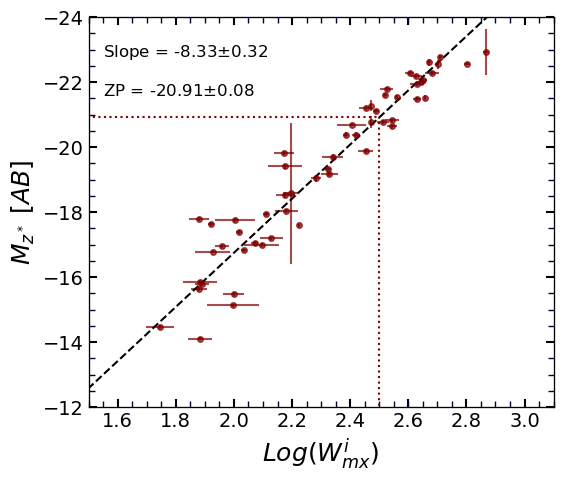

In [109]:
fig, ax = makeFig(band=band, xLim = (1.5,3.1), yLim = (-12,-24) )
plotCluster(ax, zp_calibs, offset=0, plotErrors=True, alpha=0.7, markersize=0, plotFit=True)

m0 = zp_calibs['slope']
b0 = zp_calibs['zp']
dm0 = zp_calibs['slope_e']
db0 = zp_calibs['zp_e']
mag_ = zp_calibs['MAG']
logWimx_ = zp_calibs['logWimx']
pgc_ = zp_calibs['pgc']

print m0, b0

Ylm = ax.get_ylim() ; Xlm = ax.get_xlim()
x0 = 0.97*Xlm[0]+0.03*Xlm[1]
y0 = 0.1*Ylm[0]+0.90*Ylm[1]
ax.text(x0,y0, "Slope = "+"%.2f" % m0+'$\pm$'+"%.2f" % dm0, fontsize=12, color='k')
y0 = 0.2*Ylm[0]+0.80*Ylm[1]
ax.text(x0,y0, "ZP = "+"%.2f" % b0+'$\pm$'+"%.2f" % db0, fontsize=12, color='k')

In [110]:
from bokeh.plotting import *
from bokeh.embed import components
from bokeh.models import ColumnDataSource, LabelSet, HoverTool, Range1d, Label, TapTool, OpenURL, CustomJS, CrosshairTool

output_notebook()

Loading BokehJS ...

In [113]:
if True:
    
    hover = HoverTool(tooltips=[ 
        ("LogWimx", "@LogWimx"),
        (band, "@"+band),
        ("PGC", "@PGC"),
        ])

    hover.point_policy='snap_to_data'
    hover.line_policy='nearest'#'prev'

    TOOLS = ['pan', 'tap', 'wheel_zoom', 'box_zoom', 'reset', 'save']

    p = figure(tools=TOOLS, toolbar_location="below", plot_width=550, plot_height=450)
    p.title.text_font_size = '14pt'
    p.title.text_color = 'green'
    p.grid.grid_line_color="gainsboro"
    dye = {"u":"blue","g":"green","r":"red","i":"orange","z":"maroon","w1":"purple", 'w2': "brown"}
    rang=dye[band] 

    source = ColumnDataSource({'LogWimx': logWimx_, band: mag_, 'PGC': pgc_})
    render = p.circle('LogWimx', band, source=source, size=5, color=rang, alpha=0.7, hover_color='red', hover_alpha=1, hover_line_color='red',
                        
                        # set visual properties for selected glyphs
                        selection_fill_color=rang,

                        # set visual properties for non-selected glyphs
                        nonselection_fill_alpha=1,
                        nonselection_fill_color=rang,)
    
    x = np.linspace(-5,5,50)
    p.line(x, m0*(x-2.5)+b0, line_width=1, color="black", line_dash='dashed')
    p.legend.location = "top_right"

    p.x_range = Range1d(1.5,3.1)
    p.y_range = Range1d(-12,-24)

    p.xaxis.axis_label = 'Log(W^i_mx)'
    p.yaxis.axis_label = band+'* [mag]'
    p.xaxis.axis_label_text_font_size = "14pt"
    p.yaxis.axis_label_text_font_size = "14pt"
    p.grid.grid_line_color="gainsboro"
    p.yaxis.major_label_text_font_size = "12pt"
    p.xaxis.major_label_text_font_size = "12pt"
    
    
    code = """
        
        var index_selected = source.selected['1d']['indices'][0];
        var win = window.open("http://edd.ifa.hawaii.edu/cf4_photometry/get_sdss_cf4.php?pgc="+source.data['PGC'][index_selected]+"#t01", "EDDesn", "width=1200, height=1000");
        try {win.focus();} catch (e){}

    """

    taptool = p.select(type=TapTool)
    taptool.callback = CustomJS(args=dict(source=source), code=code)



    ttp = """
        <div>
            <div>
                <span style="font-size: 16px; color: blue;">PGC:</span>
                <span style="font-size: 16px; font-weight: bold;">@PGC{int}</span>
            </div>
            <div>
                <span style="font-size: 16px; color: blue;">LogWimx:</span>
                <span style="font-size: 16px; font-weight: bold;">@LogWimx</span>
            </div>  
            <div>
                <span style="font-size: 16px; color: blue;">"""+band+""":</span>
                <span style="font-size: 16px; font-weight: bold;">@"""+band+"""{0.2f}</span>
            </div>          
        </div>
    """


    hover = HoverTool(tooltips=ttp, renderers=[render])

    hover.point_policy='snap_to_data'
    hover.line_policy='nearest'
    #hover.mode='vline'
    p.add_tools(hover)   

    cross = CrosshairTool()
    #cross.dimensions='height'
    cross.line_alpha = 0.3
    cross.line_color = 'green'
    p.add_tools(cross)     

    mytext = Label(x=20, y=290, text="Slope= "+"%.2f" % m0+'+-'+"%.2f" % dm0, text_color='black', text_font_size='12pt', x_units='screen', y_units='screen')
    p.add_layout(mytext)
    mytext = Label(x=20, y=260, text="ZP= "+"%.2f" % b0+'+-'+"%.2f" % db0, text_color='black', text_font_size='12pt', x_units='screen', y_units='screen')
    p.add_layout(mytext)    
    
    show(p)